In [1]:
%load_ext dotenv
%dotenv 
import os
import sys
sys.path.append(os.getenv('SRC_DIR'))
import pandas as pd
import numpy as np
import pickle
ft_path = os.getenv("CREDIT_DATA")
df_raw = pd.read_csv(ft_path)

In [2]:
from credit_data_ingredient import load_data

X, Y = load_data()

2025-02-07 15:29:15,237, credit_data_ingredient.py, 20, INFO, Getting data from ../../05_src/data/credit/cs-training.csv


# Loading Model Artifacts

Previously, we built a procedure for hyperparameter tuning. The process produces parametrized models that use the optimal parameters based on Grid Search. The models are saved in the artifact directory given by the environment variable `ARTIFACTS_DIR`.

To load a model, use `pickle.load()` within  a context manager (`with()` statement). The context manager will help close files in case of unexpected termination.

In [3]:
"""
If this cell fails due to a missing "artifacts" folder, first make sure you have Docker installed and opened. 
Secondly, ensure you go to the `./05_src/db/` directory and run `docker-compose up -d`, allowing Docker to perform 
necessary actions. Once finished, return to the `05_src` folder and run `python credit_experiment_tuning.py`. This 
script should create the artifacts folder in the data folder upon execution. Once the artifacts folder is obtained, 
re-run this cell.
"""

model_pkl_file = os.path.join(
    os.getenv('ARTIFACTS_DIR'), 
    "model_LogisticRegression_power_0.pkl" # make sure this matches the name of the pkl file inside of your artifcats folder.
    )

with open(model_pkl_file, 'rb') as file:
    pipe = pickle.load(file)

pipe

c:\Users\syeolekar\.conda\envs\dsi_participant\lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_standard',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['num_30_59_days_late',
                                                   'num_60_89_days_late',
                                                   'num_90_days_late',
                                                   'num_open_credit_loans',
                                                   'num_real_estate_loans',
                                                   'age', 'num_dependents']),
                                                 ('num_transform',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('power',
                                                                   PowerTransformer())]),
                                                  ['revolving_unsecured_line_utilization',
                                                   'monthly_income',
                                                   'debt_ratio'])])),
                ('clf', LogisticRegression(C=0.75))])

In this case, we loaded a logistic regression model. The model, however, could have been from another family of models (Random Forest, Neural Net, etc.)

Below, we will explore some model-agnostic explainability methods.

# Partial Dependence Plots

+ [Partial Dependence Plots (PDP)](https://scikit-learn.org/stable/modules/partial_dependence.html) show the relationship between the target response and the input feature. 
+ They can be constructed for one or two inputs at a time.

In [4]:
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Why do we fit again?

pipe.fit(X_train, y_train)


c:\Users\syeolekar\.conda\envs\dsi_participant\lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_standard',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['num_30_59_days_late',
                                                   'num_60_89_days_late',
                                                   'num_90_days_late',
                                                   'num_open_credit_loans',
                                                   'num_real_estate_loans',
                                                   'age', 'num_dependents']),
                                                 ('num_transform',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('power',
                                                                   PowerTransformer())]),
                                                  ['revolving_unsecured_line_utilization',
                                                   'monthly_income',
                                                   'debt_ratio'])])),
                ('clf', LogisticRegression(C=0.75))])

## Single-Feature PDP

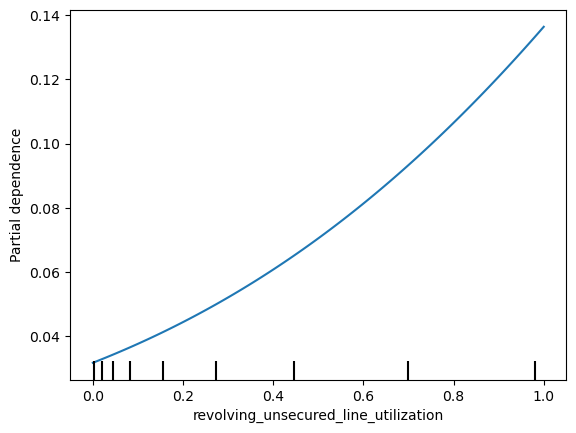

In [5]:
PartialDependenceDisplay.from_estimator(pipe, X_train, 
                                        features = ['revolving_unsecured_line_utilization'])

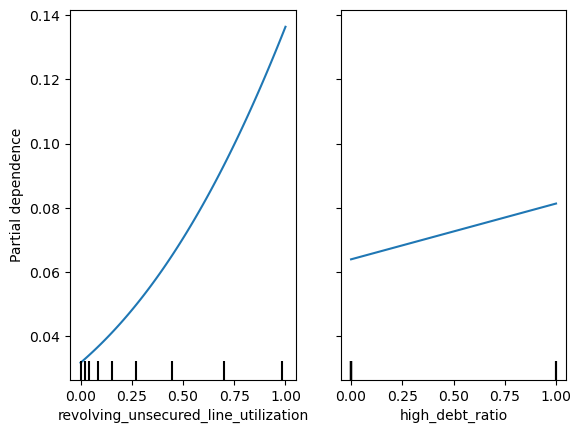

In [6]:
PartialDependenceDisplay.from_estimator(pipe, X_train, 
                                        features = ['revolving_unsecured_line_utilization', 'high_debt_ratio'])

## Two-Feature PDP

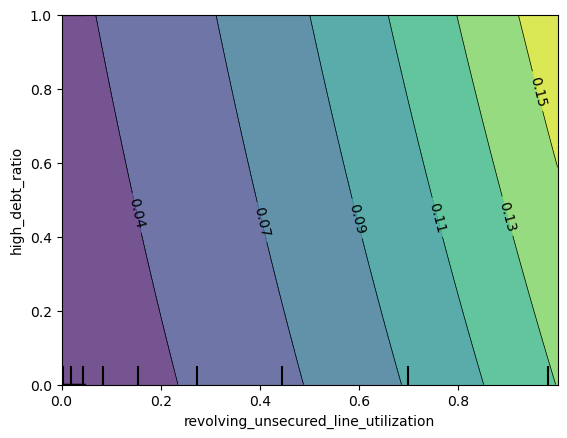

In [7]:
PartialDependenceDisplay.from_estimator(pipe, X_train, 
                                        features = [('revolving_unsecured_line_utilization', 'high_debt_ratio')])

## Partial Dependence Values

You may require the underlying data of the plots above. To obtain it, use the function [`partial_dependence()`](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.partial_dependence.html#sklearn.inspection.partial_dependence).

In [ ]:
from sklearn.inspection import partial_dependence

partial_dependence(pipe, X_train, features = ['revolving_unsecured_line_utilization', 'high_debt_ratio'])    

## Permutation Feature Importance

+ Permutation feature importance measures the contribution of each feature to a fitted model's performance.
+ Randomly shuffles the values of a single feature and observing the result degradation of the model's score. If shuffling a feature greatly degrades performance, then we say the feature is important.
+ Shuffling is involved, therefore it is convenient (and costly) to perform several repetitions.

[Scikit's Documentation](https://scikit-learn.org/stable/modules/permutation_importance.html) makes this warning:

> **Warning**: Features that are deemed of **low importance for a bad model** (low cross-validation score) could be **very important for a good model**. Therefore it is always important to evaluate the predictive power of a model using a held-out set (or better with cross-validation) prior to computing importances. Permutation importance does not reflect to the intrinsic predictive value of a feature by itself but how important this feature is for a particular model. 

In [8]:
from sklearn.inspection import permutation_importance

pi_res = permutation_importance(
    pipe, X_test, y_test, 
    n_repeats=30, 
    scoring = "neg_log_loss")

The function returns a dictionary with the following entries:

+ `importances_mean`: mean of feature importance.
+ `importances_std`: standard deviation of feature importance over n_repeats.
+ `importances`: raw permutation importance scores (one feature per row, one reshuffle per column).

In [9]:
importances_dt = pd.DataFrame(pi_res.importances).T
importances_dt.columns = X_test.columns

C:\Users\syeolekar\AppData\Local\Temp\ipykernel_27784\2910106254.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(importances_dt, vert = False,  labels = importances_dt.columns)


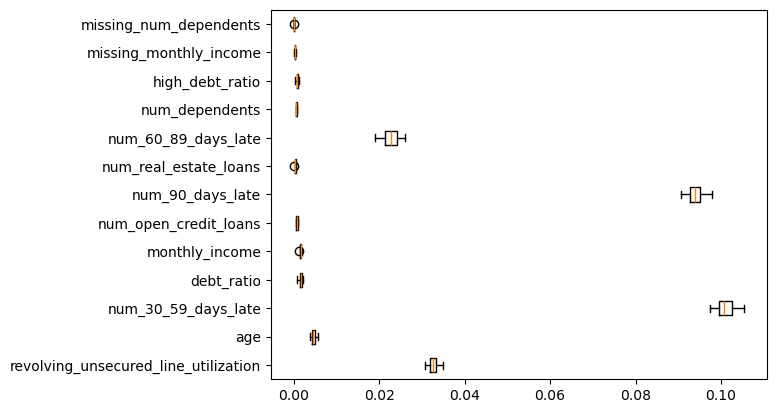

In [10]:
import matplotlib.pyplot as plt
bp = plt.boxplot(importances_dt, vert = False,  labels = importances_dt.columns)

In [11]:
pd.concat(
    [
        pd.Series(pi_res.importances_mean, index = X_test.columns, name = 'Mean Importance'),
        pd.Series(pi_res.importances_std, index = X_test.columns, name = "Std Importance")
    ], 
    axis = 1).sort_values("Mean Importance", ascending  = False)

,Mean Importance,Std Importance
num_30_59_days_late,0.100926,0.001935
num_90_days_late,0.093902,0.001706
revolving_unsecured_line_utilization,0.032737,0.000977
num_60_89_days_late,0.022629,0.001769
age,0.004562,0.000420
debt_ratio,0.001626,0.000314
monthly_income,0.001605,0.000145
high_debt_ratio,0.000797,0.000198
num_open_credit_loans,0.000715,0.000168
num_dependents,0.000617,0.000108


## SHAP Values


+ SHAP is an advanced approach for providing explanation to model results. 
+ One library that implements this procedure is [Shap](https://shap.readthedocs.io/en/latest/).


### Explainers

+ SHAP values can be calculated for any model, however, the procedure can be computationally expensive.
+ For certain models, some specific functions exist to speed the cauclations: they are contained in the [`shap.explainers`](https://shap.readthedocs.io/en/latest/api.html#explainers) module. A few noteable functions are:

    - [`shap.Explainer()`](https://shap.readthedocs.io/en/latest/generated/shap.Explainer.html#shap.Explainer): the primary explainer interface and chooses the explanation algorithm for you.
    - [`shap.TreeExplainer()`](https://shap.readthedocs.io/en/latest/generated/shap.TreeExplainer.html#shap.TreeExplainer): implements Tree Shap, a procedure optimized for tree-based ensemble methods (Random Forest, XGBoost, etc.)
    - [`shap.LinearExplainer()`](https://shap.readthedocs.io/en/latest/generated/shap.LinearExplainer.html#shap.LinearExplainer): computes SHAP Values for linear methods.

### Obtaining explanations from shap

+ Shap can obtain local and global explanations. The model produces additive explanations, therefore, obtaining global explanations is equivalent to obtaining individual explanations for all samples.
+ Shap can obtain explanations for testing and training samples.
+ Local explanations are obtained as shap_values, which reflect the contribution of each feature to the prediction made for each sample.

### Using the shap package

+ SHAP works on classifiers, but our pipelines contain preprocessing and classification steps. 
+ We can access each individual step through the `.named_steps` attirbute.
+ Notice that we apply the transformation (`ColumnTransformer`) step to obtain transformed data and store the results in `data_transform`.
+ Feature names are obtained from the preprocessor's `.get_feature_names_out()` which exposes the names of the features after they have been transformed by the `ColumnTransformer`.
+ The explainer object is then use to provide all explanations in `data_transform`.

In [12]:
import shap
data_transform = pipe.named_steps['preproc'].transform(X_test)

explainer = shap.explainers.Linear(
    pipe.named_steps['clf'], 
    data_transform,
    feature_names = pipe.named_steps['preproc'].get_feature_names_out())

shap_values = explainer(data_transform)


c:\Users\syeolekar\.conda\envs\dsi_participant\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Waterfall Plots

From [SHAP's documentation](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/waterfall.html) (emphasis added):


> Waterfall plots are designed to display explanations for **individual predictions**, so they expect a single row of an Explanation object as input. The bottom of a waterfall plot starts as the expected value of the model output, and then each row shows how the positive (red) or negative (blue) contribution of each feature moves the value from the expected model output over the background dataset to the model output for this prediction.

+ The waterfall plot below shows the contribution of each feature to an individual prediction. 
+ Only the most important features are shown, while the least important features are grouped together at the bottom of the chart (e.g., "4 other features").



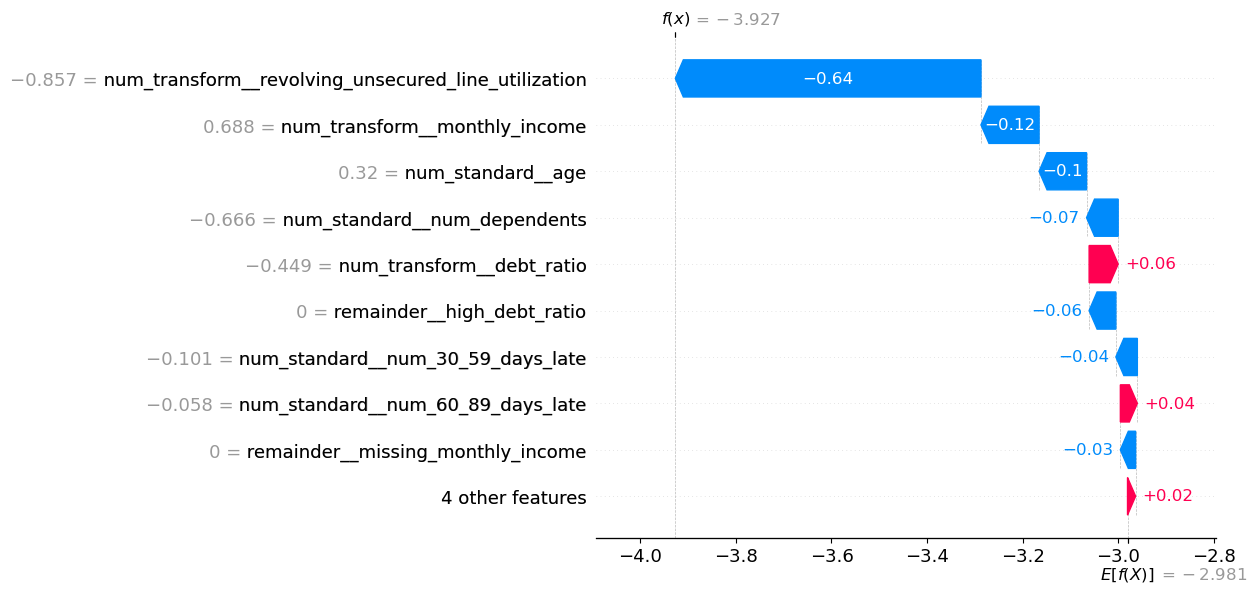

In [13]:
shap.plots.waterfall(shap_values[1])

### Beeswarm plot

+ Beeswarm plots display the contributions of each feature to all cases in the sample. The feature values are color-coded when available. 
+ Beeswarm plots summarize the behaviour of the model across all items in the sample.


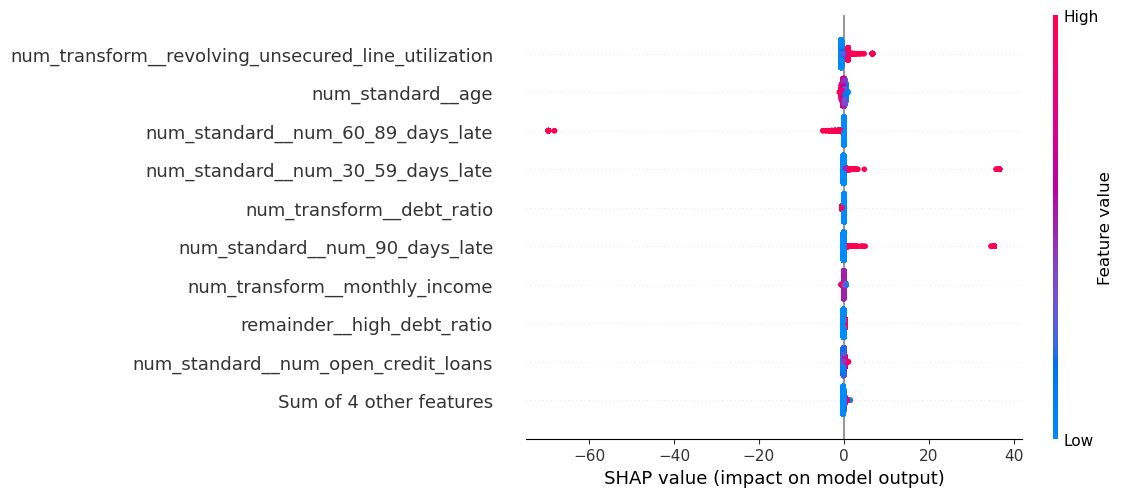

In [14]:
shap.plots.beeswarm(shap_values)